In [1]:
from dosing_rl_gym.envs.diabetic_env import Diabetic2Env

In [2]:
"""
inspired by https://github.com/dennybritz/reinforcement-learning/blob/master/DQN/Deep%20Q%20Learning%20Solution.ipynb
code adapted and modified by Yichen Jiang, ycjiang@stanford.edu
"""

'\ninspired by https://github.com/dennybritz/reinforcement-learning/blob/master/DQN/Deep%20Q%20Learning%20Solution.ipynb\ncode adapted and modified by Yichen Jiang, ycjiang@stanford.edu\n'

In [3]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
    sys.path.append("../") 

#from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [4]:
env = Diabetic2Env()
env.set_episode_length(10)

In [5]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

StandardScaler()

In [6]:
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))


FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [7]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
                
        # TODO: Implement this!
        if a is not None:
            prediction = self.models[a].predict([self.featurize_state(s)])
            return prediction[0]
        
        else:
            predictions = np.array([self.models[i].predict([self.featurize_state(s)]) for i in range(env.action_space.n)])
            return predictions.reshape(-1)
            
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        # TODO: Implement this!
        self.models[a].partial_fit([self.featurize_state(s)], [y])


In [8]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [11]:
def q_learning(env, estimator, num_episodes, discount_factor, epsilon, epsilon_decay, test_episodes):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
        test_episodes: Number of episodes in test time
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    nA = env.action_space.n
    
    # Keeps track of useful statistics
    
    episode_lengths=np.zeros(num_episodes)
    episode_rewards=np.zeros(num_episodes)
    final_reward = []
    final_glucose = []
    start_track = False
    
    for i_episode in range(num_episodes):
        
        #check whether we need to record the final reward lists
        if i_episode == num_episodes - 1:
            start_track = True
            
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, nA)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward))
        sys.stdout.flush()
        
        # TODO: Implement this!
        state = env.reset()
        
        for t in itertools.count():            
            
            # sample the action from the epsilon greedy policy
            action = np.random.choice(nA, p=policy(state))
            
            # Perform the action -> Get the reward and observe the next state
            new_state, reward, are_we_done, _ = env.step(action)
            new_action = np.random.choice(nA, p=policy(new_state))
            
            if start_track:
                final_reward.append(reward)
                final_glucose.append(new_state[0])
                        
            episode_rewards[i_episode] += reward
            episode_lengths[i_episode] = t
            
            q_values_new_state = estimator.predict(new_state)

            # value that we should have got
            # The Q-learning target policy is a greedy one, hence the `max`
            td_target = reward + discount_factor * np.max(q_values_new_state)
            estimator.update(state, action, td_target)            
            
            # update current state
            state = new_state
            
            if are_we_done:
                break
                
    
    """
    test section
    """
    test_rewards = np.zeros([test_episodes, 143])
    total_rewards = 0
    
    for i_test in range(test_episodes):
        policy = make_epsilon_greedy_policy(
            estimator, 0, nA)
        final_glucose = []
        
        print("\rTest Episode {}/{}".format(i_test + 1, test_episodes))
        sys.stdout.flush()
        
        # TODO: Implement this!
        state = env.reset()
        
        for t in itertools.count():            
            
            # sample the action from the epsilon greedy policy
            action = np.random.choice(nA, p=policy(state))
            
            # Perform the action -> Get the reward and observe the next state
            new_state, test_reward, are_we_done, _ = env.step(action)
            
            test_rewards[i_test][t] = test_reward
            total_rewards += test_reward

            
            # update current state
            state = new_state
            final_glucose.append(state[0])
            
            if are_we_done:
                break
    
    total_rewards = total_rewards / test_episodes
    plot_rewards = np.sum(test_rewards, axis = 0) / test_episodes    
    
    return episode_lengths, episode_rewards, final_reward, total_rewards, plot_rewards, final_glucose

In [12]:
def random_model(env, num_episodes):
    """
    Used as a baseline, the model would randomly choose action for each state
    """
    nA = env.action_space.n
    
    #episode_lengths=np.zeros(num_episodes)
    random_episode_rewards=np.zeros(num_episodes)
    total_rewards = 0
    test_rewards = np.zeros([num_episodes, 143])
    start_track = False
    glucose_levels = []
    
    for i_episode in range(num_episodes):
        if i_episode == num_episodes - 1:
            start_track = True
        
        last_reward = random_episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward))
        sys.stdout.flush()
        
        # TODO: Implement this!
        state = env.reset()
        
        for t in itertools.count():
            
            # sample the action from the epsilon greedy policy
            action = np.random.choice(nA)
            
            # Perform the action -> Get the reward and observe the next state
            new_state, reward, terminated, _ = env.step(action)
            new_action = np.random.choice(nA)
            
            test_rewards[i_episode][t] = reward
            total_rewards += reward
            
            #if start_track:
                #final_reward.append(reward)
                        
            random_episode_rewards[i_episode] += reward       
            
            # update current state
            state = new_state
            
            glucose_levels.append(state[0])
            
            if terminated:
                break
    
    total_rewards = total_rewards / num_episodes
    plot_rewards = np.sum(test_rewards, axis = 0) / num_episodes
    
    return random_episode_rewards, total_rewards, plot_rewards, glucose_levels

In [13]:
estimator = Estimator()

In [14]:
episode_len, episode_r, final_r, total_r, plot_r, final_glu = q_learning(env, estimator, 150, discount_factor=0.9, epsilon=0.5, epsilon_decay=0.95, test_episodes = 100)

Episode 1/150 (0.0)
Episode 2/150 (-132.09367511883187)
Episode 3/150 (-121.5609641612062)
Episode 4/150 (-116.14532473026634)
Episode 5/150 (-129.7971078351676)
Episode 6/150 (-86.07504549870082)
Episode 7/150 (-55.2056271258577)
Episode 8/150 (-42.287818448717374)
Episode 9/150 (-127.67398779025143)
Episode 10/150 (-132.86006307706313)
Episode 11/150 (-122.2438961265911)
Episode 12/150 (-125.73727009531588)
Episode 13/150 (-140.7793130093798)
Episode 14/150 (-125.34315326068469)
Episode 15/150 (-131.72993891967758)
Episode 16/150 (-130.84933481324106)
Episode 17/150 (-32.75598619470665)
Episode 18/150 (-87.45798652743915)
Episode 19/150 (-79.01627228857764)
Episode 20/150 (-62.9583046074705)
Episode 21/150 (-114.81762942594602)
Episode 22/150 (-128.03675577253074)
Episode 23/150 (-106.15962704645601)
Episode 24/150 (-108.26969869391793)
Episode 25/150 (-128.28027380031068)
Episode 26/150 (-37.43437531830783)
Episode 27/150 (-23.71573390413611)
Episode 28/150 (-20.302465889444942)
Epi

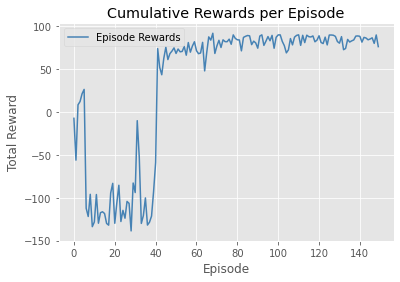

In [28]:
episodes = range(150)
#plt.figure(facecolor='white')
plt.plot(episodes, episode_r, color='steelblue', label='Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Cumulative Rewards per Episode')
plt.legend()
#plt.gca().set_facecolor('white')
plt.show

plt.savefig('./cumulative reward.png')

Average Cumulative Reward: 84.0966633916544


Text(0.5, 1.0, 'Average Reward')

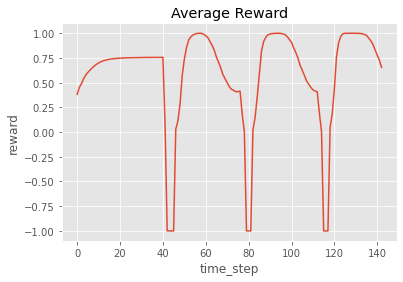

In [52]:
print("Average Cumulative Reward: {}".format(total_r))

avfa_reward = np.array(plot_r).astype(np.double)
xs = np.arange(len(plot_r))
s1 = np.isfinite(avfa_reward)

plt.plot(xs[s1], avfa_reward[s1], linestyle='-')
plt.xlabel("time_step")
plt.ylabel("reward")
plt.title("Average Reward")

In [53]:
"""
avfa_glucose = np.array(final_g).astype(np.double)
xs = np.arange(len(final_g))

plt.plot(xs, avfa_glucose, linestyle='-')
"""

"\navfa_glucose = np.array(final_g).astype(np.double)\nxs = np.arange(len(final_g))\n\nplt.plot(xs, avfa_glucose, linestyle='-')\n"

In [15]:
random_episode_r, random_r, plot_random_r, patient_glucose_levels = random_model(env, num_episodes=100)

Episode 1/100 (0.0)
Episode 2/100 (-127.38915009058738)
Episode 3/100 (-108.90897577904644)
Episode 4/100 (-122.77218672873724)
Episode 5/100 (-119.09454461153395)
Episode 6/100 (-125.9801227212188)
Episode 7/100 (-120.04029365019437)
Episode 8/100 (-135.74023805556948)
Episode 9/100 (-123.57557067531795)
Episode 10/100 (-108.93414342819337)
Episode 11/100 (-101.88396406445712)
Episode 12/100 (-129.34239984843444)
Episode 13/100 (-86.2712643070215)
Episode 14/100 (-135.2952639582096)
Episode 15/100 (-99.35405167041613)
Episode 16/100 (-125.48653260635322)
Episode 17/100 (-133.3290226254116)
Episode 18/100 (-111.58674216109785)
Episode 19/100 (-127.34814844177619)
Episode 20/100 (-132.79902317655745)
Episode 21/100 (-125.18346410039337)
Episode 22/100 (-109.30236984319245)
Episode 23/100 (-137.57966598619927)
Episode 24/100 (-114.48553382623159)
Episode 25/100 (-98.31142248486584)
Episode 26/100 (-115.4939018422294)
Episode 27/100 (-120.6712267858265)
Episode 28/100 (-109.17304302661135

Average Cumulative Reward: -119.6019378336249


Text(0.5, 1.0, 'Average Reward')

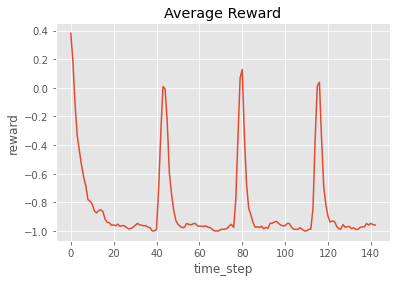

In [55]:
print("Average Cumulative Reward: {}".format(random_r))

random_reward = np.array(plot_random_r).astype(np.double)
xs = np.arange(len(plot_random_r))
s2 = np.isfinite(random_reward)

plt.plot(xs[s2], random_reward[s2], linestyle='-')
plt.xlabel("time_step")
plt.ylabel("reward")
plt.title("Average Reward")

Average Cumulative Reward of AVFA agent: 84.0966633916544
Average Cumulative Reward of Random agent: -119.6019378336249


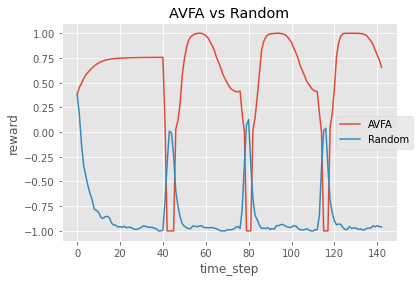

In [75]:
print("Average Cumulative Reward of AVFA agent: {}".format(total_r))
print("Average Cumulative Reward of Random agent: {}".format(random_r))

plt.plot(xs[s1], avfa_reward[s1], linestyle='-', label = 'AVFA')
plt.plot(xs[s2], random_reward[s2], linestyle='-', label = 'Random')
plt.xlabel("time_step")
plt.ylabel("reward")
plt.title("AVFA vs Random")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center right', borderaxespad=0)
plt.savefig('./comparison plot.png')
plt.show()

# Plotting Section

In [17]:
import torch.nn as nn
import seaborn as sns

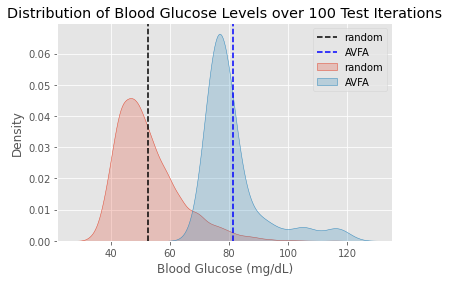

<Figure size 432x288 with 0 Axes>

In [21]:
avfa_glucose_levels = np.array(final_glu)
patient_glucose_levels = np.array(patient_glucose_levels)

sns.kdeplot(patient_glucose_levels, fill=True, label='random')
sns.kdeplot(avfa_glucose_levels, fill=True, label='AVFA')

# Adding vertical lines for mean or target glucose levels if needed
plt.axvline(x=patient_glucose_levels.mean(), color='k', linestyle='--', label='random')
plt.axvline(x=avfa_glucose_levels.mean(), color='b', linestyle='--', label='AVFA')

# Adding labels and title
plt.xlabel('Blood Glucose (mg/dL)')
plt.ylabel('Density')
plt.title('Distribution of Blood Glucose Levels over 100 Test Iterations')
plt.legend()

# Display the plot
plt.show()
plt.savefig('./wave plot.png')

# Used for test

In [18]:
def make_epsilon_greedy_policy_with_meal(meal_estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        inst_reward = meal_estimator.predict(observation)
        best_action = np.argmax(inst_reward)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [30]:
class Meal_Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.meal_models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.meal_featurize_state(env.reset())], [0])
            self.meal_models.append(model)
    
    def meal_featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
                
        # TODO: Implement this!
        if a is not None:
            prediction = self.meal_models[a].predict([self.meal_featurize_state(s)])
            return prediction[0]
        
        else:
            predictions = np.array([self.meal_models[i].predict([self.meal_featurize_state(s)]) for i in range(env.action_space.n)])
            return predictions.reshape(-1)
            
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        # TODO: Implement this!
        self.meal_models[a].partial_fit([self.meal_featurize_state(s)], [y])


In [87]:
def q_learning_improve(env, estimator, meal_estimator, num_episodes, discount_factor, epsilon, epsilon_decay, meal_start_level):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    nA = env.action_space.n
    
    # Keeps track of useful statistics
    
    episode_lengths=np.zeros(num_episodes)
    episode_rewards=np.zeros(num_episodes)
    final_reward = []
    start_track = False
    
    for i_episode in range(num_episodes):
        
        #check whether we need to record the final reward lists
        if i_episode == num_episodes - 1:
            start_track = True
            
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, nA)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward))
        sys.stdout.flush()
        
        # TODO: Implement this!
        state = env.reset()
        
        for t in itertools.count():
            
            # sample the action from the epsilon greedy policy
            action = np.random.choice(nA, p=policy(state))
            
            #check whether meal_disturbances come in
            meal = False
            if state[6] > (meal_start_level * 1.1):
                """
                meal = True
                meal_policy = make_epsilon_greedy_policy(meal_estimator, epsilon * epsilon_decay**i_episode, nA)
                meal_action = np.random.choice(nA, p = meal_policy(state))
                _a, meal_reward, _b, _c = env.step(meal_action)
                meal_estimator.update(state, meal_action, meal_reward)
                if start_track:
                    final_reward.append(meal_reward)
                episode_rewards[i_episode] += meal_reward
                episode_lengths[i_episode] = t
                """
                meal = True
                all_actions = np.array(range(0, nA))
                exclude = np.array([action])
                good_actions = [x for x in all_actions if x not in exclude]
                meal_action = np.random.choice(good_actions)
                _ns, meal_reward, _awd, _ = env.step(meal_action)
            
            # Perform the action -> Get the reward and observe the next state
            new_state, reward, are_we_done, _ = env.step(action)
            new_action = np.random.choice(nA, p=policy(new_state))
            
            if start_track:
                if meal:
                    final_reward.append(meal_reward)
                else:
                    final_reward.append(reward)
            
            if meal:
                episode_rewards[i_episode] += meal_reward
            else:
                episode_rewards[i_episode] += reward
            episode_lengths[i_episode] = t
            
            q_values_new_state = estimator.predict(new_state)

            # value that we should have got
            # The Q-learning target policy is a greedy one, hence the `max`
            td_target = reward + discount_factor * np.max(q_values_new_state)
            estimator.update(state, action, td_target)
             
            # update current state
            state = new_state
            
            if are_we_done:
                break
    
    return episode_lengths, episode_rewards, final_reward

In [88]:
estimator = Estimator()
meal_estimator = Meal_Estimator()

In [89]:
m_episode_len, m_episode_r, m_final_r = q_learning_improve(env, estimator, meal_estimator, 150, discount_factor=0.8, epsilon=0.5, epsilon_decay=0.95, meal_start_level=1000)

Episode 1/150 (0.0)
Episode 2/150 (-108.18175097305273)
Episode 3/150 (-52.94353416316258)
Episode 4/150 (-121.2318075018591)
Episode 5/150 (20.13926707539044)
Episode 6/150 (-16.208660623582922)
Episode 7/150 (-103.90566509486996)
Episode 8/150 (-108.53201842036637)
Episode 9/150 (-97.56748696545797)
Episode 10/150 (-111.00719005123364)
Episode 11/150 (-111.710604358317)
Episode 12/150 (-118.72815509688964)
Episode 13/150 (-117.22480374414526)
Episode 14/150 (-115.03496804640658)
Episode 15/150 (-99.17730492425541)
Episode 16/150 (14.246257305372154)
Episode 17/150 (37.14581050284809)
Episode 18/150 (34.80215586787242)
Episode 19/150 (18.90569790602993)
Episode 20/150 (18.77996647397046)
Episode 21/150 (46.408717134588436)
Episode 22/150 (26.61911613063474)
Episode 23/150 (37.814655576324)
Episode 24/150 (13.671695316808067)
Episode 25/150 (9.041022046660972)
Episode 26/150 (28.3209357175308)
Episode 27/150 (30.73157952946331)
Episode 28/150 (34.63035130455309)
Episode 29/150 (30.3863

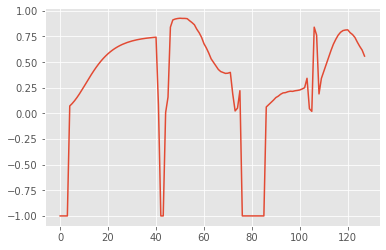

In [92]:
meal_reward = np.array(m_final_r).astype(np.double)
xs = np.arange(len(m_final_r))
s3 = np.isfinite(meal_reward)

plt.plot(xs, meal_reward, linestyle='-')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 128 but corresponding boolean dimension is 143

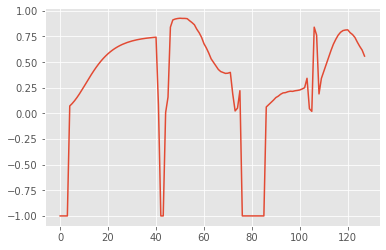

In [93]:
plt.plot(xs[s3], meal_reward[s3], linestyle='-')
plt.plot(xs[s2], random_reward[s2], linestyle='-')
plt.show()

# With random meal disturbances and episode = 300

In [16]:
episode_len, episode_r, final_r = q_learning(env, estimator, 300, discount_factor=0.9, epsilon=0.5, epsilon_decay=0.95)

Episode 1/300 (0.0)
Episode 2/300 (-128.88574659957715)
Episode 3/300 (-85.35168590865177)
Episode 4/300 (-108.76132187770764)
Episode 5/300 (-29.145556213977336)
Episode 6/300 (25.2425411741389)
Episode 7/300 (-17.049406767120633)
Episode 8/300 (-8.733624103206198)
Episode 9/300 (-45.604033744569314)
Episode 10/300 (5.779426045590091)
Episode 11/300 (28.730873560743444)
Episode 12/300 (-15.09975297925872)
Episode 13/300 (-24.57986833873538)
Episode 14/300 (-30.38217372006745)
Episode 15/300 (-130.39989850942322)
Episode 16/300 (-140.8681086933333)
Episode 17/300 (-140.68352026954966)
Episode 18/300 (-143.0)
Episode 19/300 (-86.70235081061307)
Episode 20/300 (-130.2745705245752)
Episode 21/300 (-136.31984494358133)
Episode 22/300 (-134.253376274576)
Episode 23/300 (-125.57263395067115)
Episode 24/300 (-133.44773281561424)
Episode 25/300 (-109.58353253442664)
Episode 26/300 (-121.71062651505702)
Episode 27/300 (-129.42644859142155)
Episode 28/300 (-133.9616489115006)
Episode 29/300 (-13

Episode 226/300 (37.410497230539235)
Episode 227/300 (12.838555343252573)
Episode 228/300 (30.900335283496776)
Episode 229/300 (19.02563354165044)
Episode 230/300 (-15.405801662073541)
Episode 231/300 (48.682519040200035)
Episode 232/300 (13.471727784984267)
Episode 233/300 (43.05576152541535)
Episode 234/300 (21.12087647536921)
Episode 235/300 (7.941549758728744)
Episode 236/300 (74.54685383226426)
Episode 237/300 (-16.498293174433186)
Episode 238/300 (33.88979976921247)
Episode 239/300 (8.994347825093882)
Episode 240/300 (58.023245848074836)
Episode 241/300 (3.2540140338513925)
Episode 242/300 (47.80986042643238)
Episode 243/300 (21.0025137466662)
Episode 244/300 (32.74936666245242)
Episode 245/300 (48.96795191502837)
Episode 246/300 (47.185956849781505)
Episode 247/300 (36.451185018227385)
Episode 248/300 (23.78170290956069)
Episode 249/300 (7.766249025656444)
Episode 250/300 (0.9900571829592857)
Episode 251/300 (43.06593459408059)
Episode 252/300 (62.26587093797626)
Episode 253/300

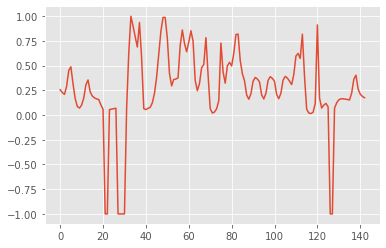

In [17]:
avfa_reward = np.array(final_r).astype(np.double)
xs = np.arange(len(final_r))
s1 = np.isfinite(avfa_reward)

plt.plot(xs[s1], avfa_reward[s1], linestyle='-')

In [19]:
random_episode_r, random_r = random_model(env, num_episodes=300)

Episode 1/300 (0.0)
Episode 2/300 (-129.30205281625518)
Episode 3/300 (-81.93047183676838)
Episode 4/300 (-131.26063024381375)
Episode 5/300 (-143.0)
Episode 6/300 (-131.51184459181917)
Episode 7/300 (-129.38474449739158)
Episode 8/300 (-138.40455741152576)
Episode 9/300 (-121.21048899425679)
Episode 10/300 (-140.52557494707327)
Episode 11/300 (-141.92436294810705)
Episode 12/300 (-131.2446384347291)
Episode 13/300 (-120.60027996401405)
Episode 14/300 (-110.31041400205275)
Episode 15/300 (-139.52663158766808)
Episode 16/300 (-137.38227837321102)
Episode 17/300 (-78.76027434258411)
Episode 18/300 (-134.10626423033233)
Episode 19/300 (-133.7580611512595)
Episode 20/300 (-112.13680807118173)
Episode 21/300 (-143.0)
Episode 22/300 (-139.99933638051363)
Episode 23/300 (-120.91498067558281)
Episode 24/300 (-136.1033110463111)
Episode 25/300 (-136.18677712502875)
Episode 26/300 (-118.75241244976245)
Episode 27/300 (-119.44964638613331)
Episode 28/300 (-122.72573268229424)
Episode 29/300 (-119

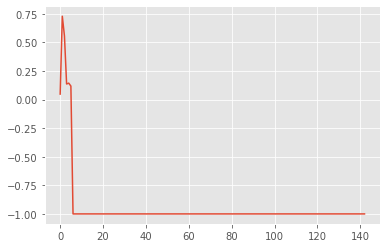

In [20]:
random_reward = np.array(random_r).astype(np.double)
xs = np.arange(len(random_r))
s2 = np.isfinite(random_reward)

plt.plot(xs[s2], random_reward[s2], linestyle='-')

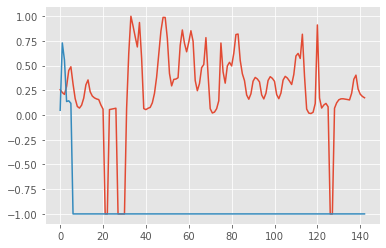

In [21]:
plt.plot(xs[s1], avfa_reward[s1], linestyle='-')
plt.plot(xs[s2], random_reward[s2], linestyle='-')
plt.show()